# The Repressilator

This notebook explores an oscillatory network of transcriptional regulators known as Repressilator. First, we will outline the protein production model, taking into account the effects of gene repressors. Then, we will introduce the Repressilator and simulate its dynamics. The following analysis is based on [[1]](#references).


This oscillatory network was successfully implemented in *Escherichia coli*, leading to periodic production of green fluorescent protein by the cells [[2]](#references). Initially developed as a proof of concept, this system aimed to show that artificial biological constructs could consistently replicate the behavior of electrical circuits. While the Repressilator itself did not have a direct practical application, it paved the way for the development of biological circuits with more practical purposes, such as systems that can count events or activate functions after a fixed period. These advancements hold potential for applications in drug delivery, nano-construction, and other fields. Additionally, the study of oscillatory networks like the Repressilator is inspired by natural biological systems, such as the circadian clocks in organisms that track and anticipate daily environmental changes. This area of research is significant, as evidenced by the [2017 Nobel Prize](https://www.nobelprize.org/prizes/medicine/2017/summary/) awarded to Jeffrey Hall, Michael Rosbash, and Michael Young for their discoveries on how internal clocks and biological rhythms govern human life.

Importing the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Modeling protein dynamics and gene regulation

### Basic protein production model

We assume that proteins are produced at a constant rate $\beta$, while they are simultaneously removed through active degradation and dilution during cell growth and division. This removal occurs at a rate proportional to the protein concentration, with the proportionality constant $\gamma$. Consequently, the rate of change in protein concentration $x$ over time is described by the following ordinary differential equation:

$$\frac{\partial x}{\partial t}=\text{production}-(\text{degradation}+\text{dilution})=\beta-\gamma \cdot x$$

### Gene regulation and repressor binding dynamics

Genes are not continuously "on" but are regulated by cellular mechanisms that adjust their expression levels based on environmental conditions and the cell's state. Repressors are crucial in this regulation; these proteins bind to specific DNA sequences near a gene's promoter, influencing gene expression. When a repressor binds, gene expression decreases, and when it unbinds, expression increases.

The binding and unbinding of repressors can be modeled as a reversible chemical reaction:

$$P+R\underset{k-}{\xrightleftharpoons{k_+}} P_{\text{bound}}$$

where $P$ is the unbound promoter, $R$ is the repressor, and $P$ bound is the promoter-repressor complex. 

The dynamics of this chemical reaction can be expressed as an ordinary differential equation. Although each DNA site within an individual cell is either bound or unbound and is thus best modeled with discrete variables, averaging over a population of cells allows us to use continuous variables to describe the mean occupancy of the site. Let $r$ be the concentration of repressor, $p$ be the concentration of unbound promoter, $p_{\text{bound}}$ be the concentration of promoter bound with a repressor, then the rate of change of the promoter concentration is given by:

$$\frac{\partial p}{\partial t}=-k_+\cdot p \cdot r + k_-\cdot p_{\text{bound}}$$

### Steady-State approximation and protein production rate

Repressor binding and unbinding to the DNA site occur much faster than changes in protein concentrations. Therefore, on the timescale of protein concentration changes, these binding dynamics quickly reach a steady state, where $\partial{p}/\partial{t}\approx 0$ (i.e., despite the ongoing binding and unbinding, their overall effect remains constant over time). Consequently, the binding dynamics can be approximated by:

$$-k_+\cdot p \cdot r + k_-\cdot p_{\text{bound}}=0$$

If $p_{\text{tot}}$ is the total concentration of promoters, bound or not, then $p_{\text{tot}}=p+p_{\text{bound}}$, and we have

$$-k_+\cdot p \cdot r + k_-\cdot (p_{\text{tot}}-p)=0$$

which can be rearranged to give the fraction of promoters that are free to allow transcription,

$$\frac{p}{p_{\text{tot}}}=\frac{k_-}{k_-+k_+\cdot r}=\frac{1}{1+\frac{k_+}{k_-}\cdot r}=\frac{1}{1+\frac{r}{K_d}}$$

where we have defined the dissociation constant for repressor-target binding

$$K_d=\frac{k_-}{k_+}$$

The rate of protein production should be proportional to the probability of the promoter being unbound, therefore

$$\beta(r)=\beta_0\cdot \frac{p}{p_{\text{tot}}}=\frac{\beta_0}{1+\frac{r}{K_d}}$$

### Ultrasensitivity and Hill function

Although the $\beta(r)$ function effectively captures the behavior of a basic transcriptional regulation model, real-world gene regulation and protein-protein interactions often display more switch-like or ultrasensitive characteristics. Ultrasensitivity can originate from various mechanisms, one key source being cooperativity in molecular interactions. For instance, when a protein binds to one DNA site, it can enhance the binding affinity of a second protein at a nearby site. In such cases, an increasing concentration of one component may initially have little effect but eventually lead to a dramatic response.

Hill function offers a method to analyze systems with ultrasensitive responses. A repressive Hill function is given by

$$f_{\text{rep}}(x)=\frac{1}{1+(\frac{x}{k})^n}$$

here, the Hill coefficient, $n$, describes the degree of ultrasensitivity. For $n=1$, this reduces to the simple repressive function discussed earlier. When $n>1$, the response becomes increasingly sharper and more ultrasensitive, approaching a perfect step function as $n$ approaches infinity, as shown in the plot below.

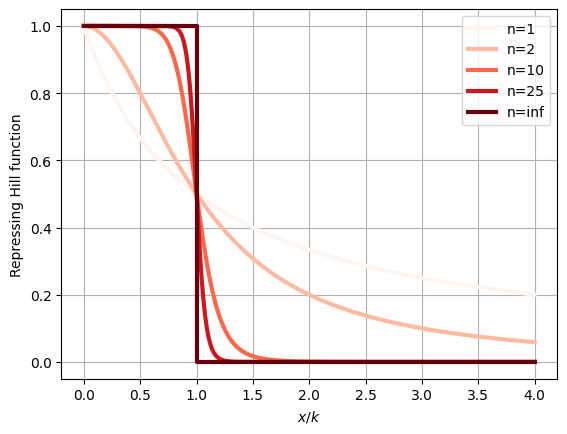

In [2]:
n_vals = [1, 2, 10, 25, np.inf]
x = np.concatenate((np.linspace(0, 1, 200), np.linspace(1, 4, 200)))
f_rep = []
for n in n_vals:
    if n == np.inf:
        f_rep.append(np.concatenate((np.ones(200), np.zeros(200))))
    else:
        f_rep.append(1 / (1 + x ** n))
df = pd.DataFrame(np.array(f_rep).T, columns=[f"n={n}" for n in n_vals])
df['x'] = x
df.plot(
    x='x', y=[f"n={n}" for n in n_vals],
    ylabel="Repressing Hill function", xlabel="$x/k$",
    colormap="Reds", linewidth=3
)
plt.grid()

The production rate of gene products under a repressor with ultrasensitivity, modeled by the Hill function, is then

$$\beta(r)=\beta_0\cdot f_{\text{rep}(r)}=\beta_0 \frac{1}{1+(\frac{r}{k})^n}$$

To simplify notation, we will omit the subscript $0$ from $\beta$ in the following discussions.

## Description and analysis of the Repressilator dynamics

### The Repressilator model

The Repressilator is a genetic regulatory network consisting of a feedback loop with at least three genes, each expressing a protein that represses the next gene in the loop. The dynamic behavior of the Repressilator mirrors the competitive interactions of the rock-paper-scissors game, as each component cyclically inhibits the next.

The system of differential equations describing the Repressilator is given by

\begin{cases}
\frac{\partial x_1}{\partial t}=\frac{\beta}{1+(\frac{x_3}{k})^n}-\gamma x_1\\
\frac{\partial x_2}{\partial t}=\frac{\beta}{1+(\frac{x_1}{k})^n}-\gamma x_2\\
\frac{\partial x_3}{\partial t}=\frac{\beta}{1+(\frac{x_2}{k})^n}-\gamma x_3\\
\end{cases}

or in a more compact form
$$\frac{\partial x_i}{\partial t}=\frac{\beta}{1+(\frac{x_j}{k})^n}-\gamma x_i$$
with $(i,j)$ pairs $(1,3),(2,1),(3,2)$.

For simplicity we assumed perfect symmetry among the species, with each one having identical biochemical properties.

### Dimensionless formulation

To simplify the equations, we introduce a dimensionless time variable $\tau$ by rescaling the original time $t$ using $\gamma$. The new dimensionless time variable $\tau$ is defined as:
$$\tau=\gamma t$$
This means that $\tau$ is a measure of time in units of $\gamma^{-1}$.

The original time derivative $\frac{\partial}{\partial t}$ can be expressed in terms of $\tau$ as:
$$\frac{\partial}{\partial t}=\frac{\partial \tau}{\partial t}\frac{\partial}{\partial \tau}=\gamma \frac{\partial}{\partial \tau}$$
since $\frac{\partial \tau}{\partial t}=\gamma$.

We now define dimensionless concentrations $x_i'$ as:
$$x_i'=\frac{x_i}{k}$$
thus
$$x_i=k x_i'$$

Substituting the above definitions into the original equations, we get:

$$\frac{\partial x_i}{\partial t}=k \gamma \frac{\partial x_i'}{\partial \tau}$$
And since
$$\frac{\partial x_i}{\partial t}= \frac{\beta}{1+(x_j')^n}-\gamma k x_i'$$
we have that
$$\frac{\partial x_i'}{\partial \tau}=\frac{\frac{\beta}{k\gamma}}{1+(x_j')^n}- x_i'=\frac{\beta'}{1+(x_j')^n}- x_i'$$
where we set $\beta'=\frac{\beta}{k \gamma}$

To simplify the notation in the following we will use $x_i$ instead of $x_i'$, $\tau$ instead of $t$ and $\beta$ instead of $\beta'$.

### Oscillatory behavior and stability analysis

The system's dynamics might result in sustained oscillation, where repressor proteins alternate in concentration: if repressor 1 is high, it leads to low levels of repressor 2, which allows repressor 3 to increase and suppress repressor 1, continuing the cycle. Alternatively, the system might also stabilize at a steady state, where all three repressors reach intermediate levels, maintaining a balance without oscillations. To effectively design clock circuits, it is essential to ensure that the system exhibits periodic oscillations that persist over time without damping out and can recover from temporary perturbations caused by environmental fluctuations or internal noise.

The system's actual behavior is influenced by its parameters, specifically the Hill coefficient $n$ and the protein production rate $\beta$. By integrating the differential equations, we can track the concentrations of three proteins over time for various values of $n$ and $\beta$, allowing us to observe how these parameters affect the system's dynamics.

Defining a function to solve the system of differential equations:

In [3]:
def repressilator_ODE_solver(x0, t, beta, n):
    """
    Solve the initial value problem for the Repressilator ODE system.
    """

    def repressilator(x, t, beta, n):
        x1, x2, x3 = x

        d_x1_dt = beta / (1 + x3 ** n) - x1
        d_x2_dt = beta / (1 + x1 ** n) - x2
        d_x3_dt = beta / (1 + x2 ** n) - x3

        return [d_x1_dt, d_x2_dt, d_x3_dt]

    y = odeint(repressilator, x0, t, args=(beta, n))
    return y.T

Solving the system for different values of $n$ and $\beta$, with initial protein concentrations set to $1$, $1$, and $1.1$ for $x_1$, $x_2$, and $x_3$, respectively (we avoided setting $x_1 = x_2 = x_3$ to prevent the dynamics from collapsing into a single equation, which would obscure differences in the proteins' behavior over time):

In [4]:
params = {
    'betas': [2, 10, 100, 2, 10, 100, 2, 10, 100, 2, 10, 100],
    'ns': [2, 2, 2, 2.5, 2.5, 2.5, 3, 3, 3, 5, 5, 5]
}

t = np.linspace(0, 40, 1000)

df = pd.DataFrame()
for beta, n in zip(params['betas'], params['ns']):
    y = repressilator_ODE_solver(x0=np.array([1, 1, 1.1]), t=t, beta=beta, n=n)
    df_temp = pd.DataFrame(y.T, columns=["$x_1$", "$x_2$", "$x_3$"])
    df_temp['$\\beta$'] = beta
    df_temp['$n$'] = n
    df_temp['t'] = t
    df = pd.concat([df, df_temp])

Plotting the results:

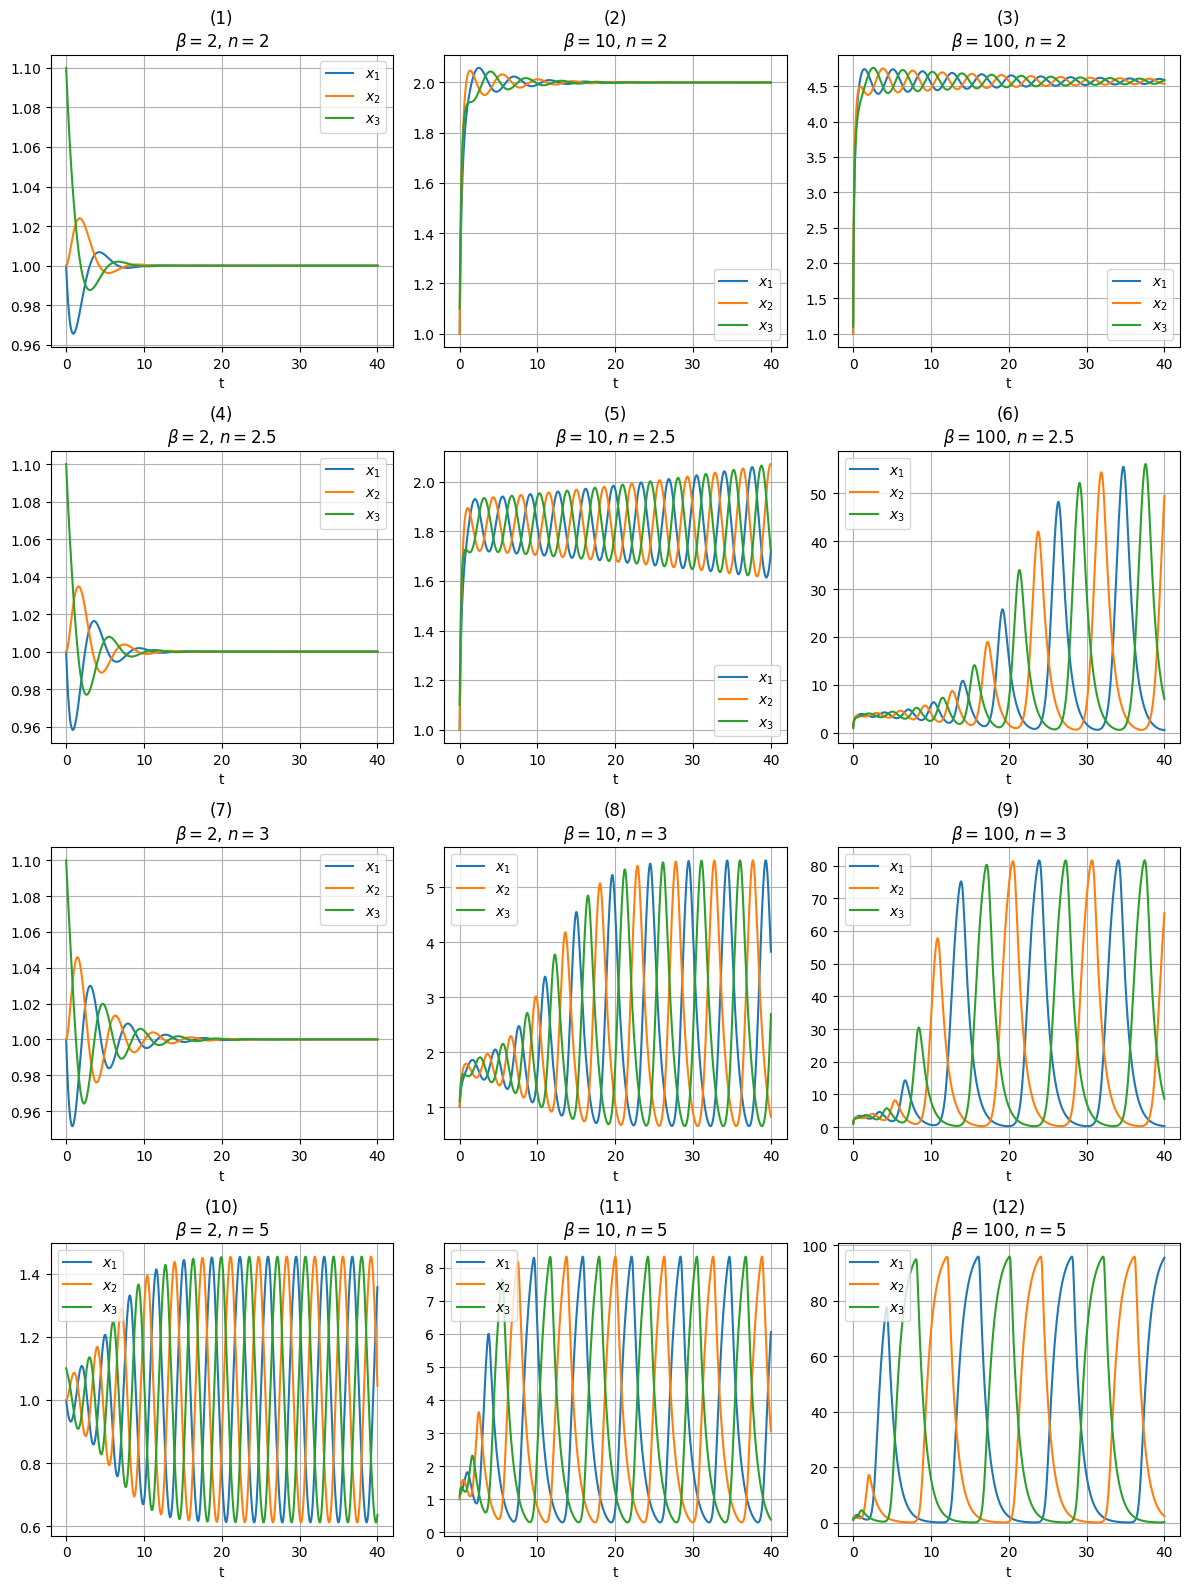

In [5]:
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
for i, (beta, n) in enumerate(zip(params['betas'], params['ns'])):
    df_temp = df[(df['$\\beta$'] == beta) & (df['$n$'] == n)]
    df_temp.plot(
        x='t', y=["$x_1$", "$x_2$", "$x_3$"],
        xlabel="t",
        title=f"({i+1})\n$\\beta={beta}$, $n={n}$",
        ax=axs[int(i/3), i%3]
    )
    axs[int(i/3), i%3].grid()
plt.tight_layout()

The parameter combinations used in plots $(1), (2), (3), (4)$, and $(7)$ lead the system to stabilize at a fixed point, without exhibiting oscillatory behavior.

### Design considerations for oscillatory systems

Through linear stability analysis, it can be proven that the fixed point is unstable (the system exhibits sustained oscillations) for $n>2$ and $\beta > \frac{n}{2}(\frac{n}{2}-1)^{-\frac{n+1}{n}}$.

We can display the regions of stability and instability in the $n$-$\beta$ plane, marking the parameter values used in the previous simulations:

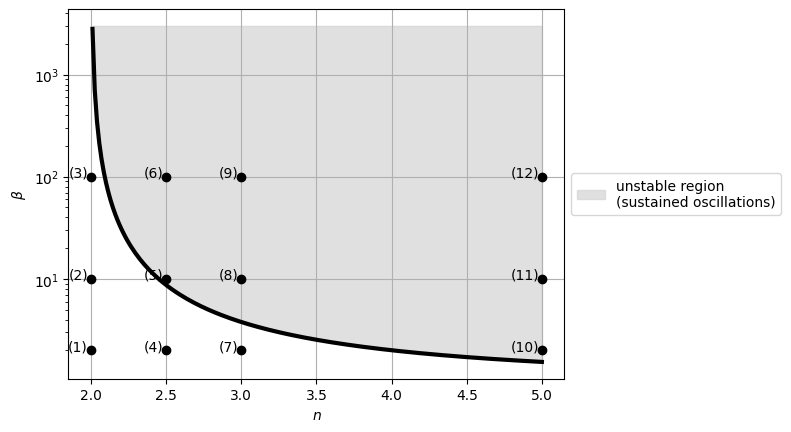

In [6]:
n = np.linspace(2.01, 5, 200)
beta = n / 2 * (n / 2 - 1) ** (-((n + 1)/n))
plt.figure()
plt.semilogy(n, beta, linewidth=3, c="black")
plt.fill_between(n, beta, 3000, color="lightgray", alpha=0.7, label="unstable region\n(sustained oscillations)")
plt.xlabel("$n$")
plt.ylabel("$\\beta$")
for i, (beta, n) in enumerate(zip(params['betas'], params['ns'])):
    plt.scatter(n, beta, c="black", zorder=10)
    plt.text(n-0.02, beta, f"({i+1})", fontsize=10, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, zorder=0)

The plot indicates that, from a design perspective, maximizing both $\beta$ and $n$ is crucial for ensuring sustained oscillations in the system. This requires employing strong promoters and ultrasensitive repression curves to achieve the desired oscillatory behavior.

## References

- [1] Elowitz M., Bois J. and Marken J. (2022). ["Biological Circuits Design"](https://biocircuits.github.io/chapters/09_repressilator.html). California Institute of Technology.
- [2] Elowitz M. and Leibler S. "A synthetic oscillatory network of transcriptional regulators." Nature 403.6767 (2000): 335-338.